In [49]:
import numpy as np
import matplotlib.pyplot as plt
import cmocean as cmo
import datetime
import xarray as xr
import os
import matplotlib.colors as mcolors
import cmocean as cmo
import pandas as pd
import matplotlib.dates as mdates
import geopandas as gpd
import importlib
from matplotlib.colors import LogNorm

In [3]:
plt.style.use('../ccic.mplstyle')

# Interpolation/masking

Just a sanity check to see if all looks okay for a single day of data. Actual interpolation and masking is done as pre-processing step.

In [4]:
file_path = '/scratch/ccic_record/data/modis/ccic_modis_data_2022.nc'
dataset = xr.open_dataset(file_path)

file_path_masked = '/scratch/ccic_record/data/modis/ccic_modis_data_2022_masked.nc'
dataset_masked = xr.open_dataset(file_path_masked)

In [1]:
latitude = dataset['lat'][:]
longitude = dataset['lon'][:]
data = dataset['Cloud_Fraction_Mean'][220,:,:].values
data_filtered = np.where((data == -9999) | (data == -2147483647), np.nan, data)
data_filtered = data_filtered.astype(float) * 0.0001

mask_24 = xr.open_dataset("/scratch/ccic_record/data/mask_24.nc")

data_masked = dataset_masked['Cloud_Fraction_Mean'][220,:,:].values
data_filtered_masked = np.where((data_masked == -9999) | (data_masked < -0), np.nan, data_masked)
data_filtered_masked = data_filtered_masked.astype(float) * 0.0001

NameError: name 'dataset' is not defined

/tmp/ipykernel_2512663/3426732362.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


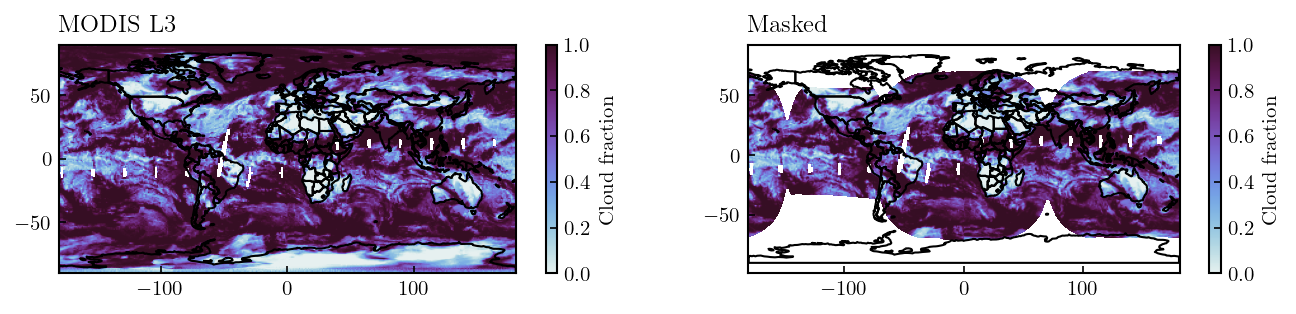

In [6]:
fig, axes = plt.subplots(1, 2, figsize = (9,2))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

extent = [longitude[0]-0.5, longitude[-1]+0.5, latitude[0]-0.5, latitude[-1]+0.5]
mask_24.latitude.values

cax = axes[0].imshow(data_filtered, extent=extent)
cbar = fig.colorbar(cax)
cbar.set_label(r'Cloud fraction')
world.boundary.plot(ax=axes[0], color='black', lw=1)
axes[0].set_title(r'MODIS L3')

cax2 = axes[1].imshow(data_filtered_masked, extent=[mask_24.longitude.values[0]-0.5, mask_24.longitude.values[-1]+0.5, mask_24.latitude.values[-1]-0.5, mask_24.latitude.values[0]+0.5])
world.boundary.plot(ax=axes[1], color='black', lw=1)
cbar2 = fig.colorbar(cax2)
cbar2.set_label(r'Cloud fraction')
axes[1].set_title(r'Masked')

fig.tight_layout()

# Time series

In [7]:
time_series = xr.open_dataset('/scratch/ccic_record/data/timeseries/modis_cf_tiwp_time_series.nc')

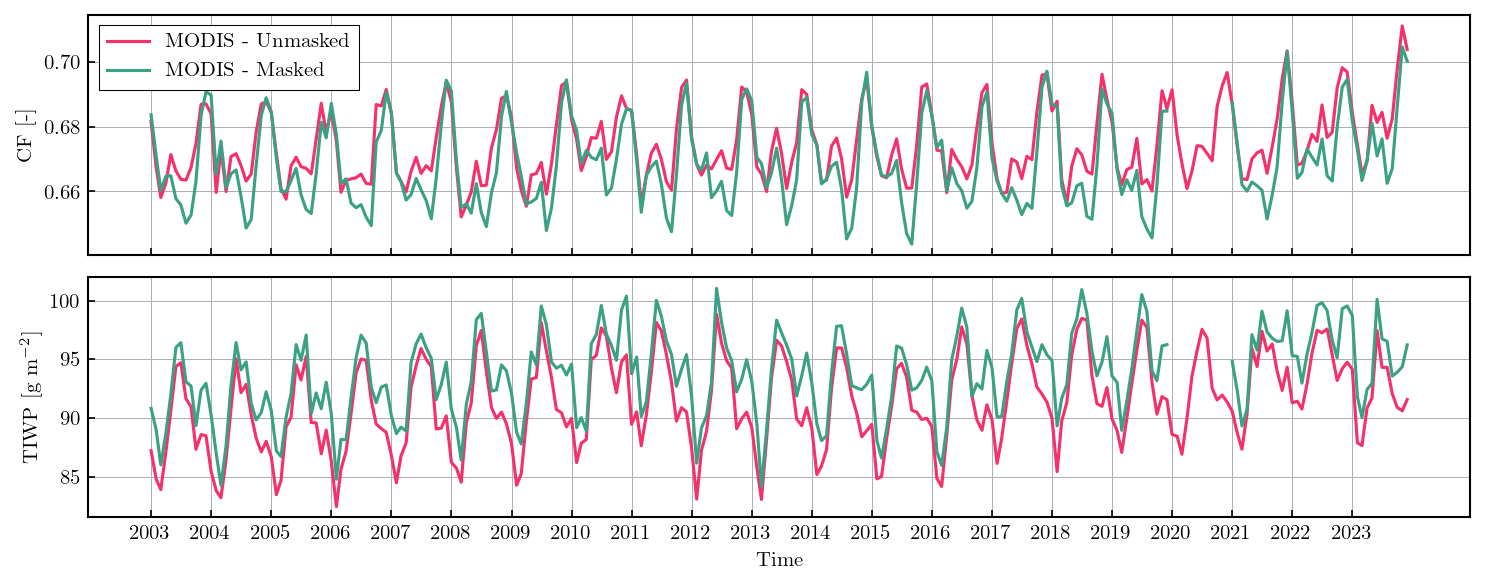

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,4))

ax1.plot(time_series['date'], time_series['CF_global_mean_unmasked'].values, label='MODIS - Unmasked')
ax1.plot(time_series['date'], time_series['CF_global_mean_masked'].values, label='MODIS - Masked')

ax2.plot(time_series['date'], time_series['TIWP_global_mean_unmasked'].values, label='MODIS - Unmasked')
ax2.plot(time_series['date'], time_series['TIWP_global_mean_masked'].values, label='MODIS - Masked')

#ax.set_ylim([0.63, 0.715])
ax1.set_xticks(time_series['date'][::12])
ax2.set_xticks(time_series['date'][::12])
ax1.set_xticklabels([])
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax2.set_xlabel('Time')

ax1.set_ylabel('CF [-]')
ax2.set_ylabel(r'TIWP [g m$^{-2}$]')

ax1.legend()

ax1.grid()
ax2.grid()

fig.tight_layout()

#plt.savefig(f'cf_tiwp_timeseries_modis.pdf', facecolor='white', bbox_inches="tight")

# Global distributions

In [52]:
def process_global_distributions(directory_path, mask):
    
    suffix_for_variable = 'masked' if mask else 'unmasked'

    lat = np.arange(-89.5, 90.5, 1)
    lon = np.arange(-179.5, 180.5, 1)
    n_lats = 180
    n_lons = 360

    CF_global_distribution_unmasked_count = np.zeros((n_lats, n_lons))
    TIWP_global_distribution_unmasked_count = np.zeros((n_lats, n_lons))
    CF_global_distribution_masked_count = np.zeros((n_lats, n_lons))
    TIWP_global_distribution_masked_count = np.zeros((n_lats, n_lons))

    ds = xr.Dataset(
        {
            "CF_global_distribution_unmasked": (("lat", "lon"), np.zeros((n_lats, n_lons))),
            "TIWP_global_distribution_unmasked": (("lat", "lon"), np.zeros((n_lats, n_lons))),
            "CF_global_distribution_masked": (("lat", "lon"), np.zeros((n_lats, n_lons))),
            "TIWP_global_distribution_masked": (("lat", "lon"), np.zeros((n_lats, n_lons))),
        },
        coords={
            "lat": lat,
            "lon": lon,
        }
    )

    mask = mask.mask == 1

    for file in os.listdir(directory_path):
        if file.endswith('.nc'):
            file_path = os.path.join(directory_path, file)

            for masked in [True, False]:
                suffix_for_variable = 'masked' if masked else 'unmasked'
                dataset = xr.open_dataset(file_path)
                if masked:
                    for var in dataset.data_vars:
                        dataset[var] = dataset[var].where(mask == 1)

                IWP = dataset.Cloud_Water_Path_Ice_Mean
                IWP = IWP.where(IWP >= 0)
    
                IWP_counts = dataset.Cloud_Retrieval_Fraction_Ice_Pixel_Counts
                IWP_counts = IWP_counts.where(IWP_counts >= 0)
            
                CF_ice = dataset.Cloud_Retrieval_Fraction_Ice * 0.0001
                CF_ice = CF_ice.where(CF_ice >= 0)
            
                CF = dataset.Cloud_Fraction_Mean * 0.0001
                CF = CF.where(CF >= 0)
                CF_counts = dataset.Cloud_Fraction_Pixel_Counts
                CF_counts = CF_counts.where(CF_counts >= 0)
    
                if masked:
                    ds["CF_global_distribution_masked"] += np.nansum(CF * CF_counts, axis=0)
                    CF_global_distribution_masked_count += np.nansum(CF_counts, axis=0)
                
                    ds["TIWP_global_distribution_masked"] += np.nansum(IWP * CF_ice * IWP_counts, axis=0)
                    TIWP_global_distribution_masked_count += np.nansum(
                        IWP_counts, axis=0
                    )
                else:
                    ds["CF_global_distribution_unmasked"] += np.nansum(CF * CF_counts, axis=0)
                    CF_global_distribution_unmasked_count += np.nansum(CF_counts, axis=0)
                
                    ds["TIWP_global_distribution_unmasked"] += np.nansum(IWP * CF_ice * IWP_counts, axis=0)
                    TIWP_global_distribution_unmasked_count += np.nansum(
                        IWP_counts, axis=0
                    )
                dataset.close()

    ds["CF_global_distribution_unmasked"] /= CF_global_distribution_unmasked_count
    ds["TIWP_global_distribution_unmasked"] /= TIWP_global_distribution_unmasked_count
    ds["CF_global_distribution_masked"] /= CF_global_distribution_masked_count
    ds["TIWP_global_distribution_masked"] /= TIWP_global_distribution_masked_count
    
    return ds

    

In [53]:
process_global_dist = False

if process_global_dist:
    mask = xr.open_dataset("../mask_24_for_modis.nc")
    modis_data_dir = '../../data/'
    
    global_dist = process_global_distributions(modis_data_dir, mask)
    global_dist.to_netcdf('global_distribution_cf_tiwp_modis.nc')

else:
    global_distribution = xr.open_dataset("/scratch/ccic_record/data/global_distribution_cf_tiwp_modis.nc")

../../data/ccic_modis_data_2019.nc
../../data/ccic_modis_data_2016.nc
../../data/ccic_modis_data_2015.nc
../../data/ccic_modis_data_2009.nc
../../data/ccic_modis_data_2011.nc
../../data/ccic_modis_data_2004.nc
../../data/ccic_modis_data_2021.nc
../../data/ccic_modis_data_2013.nc
../../data/ccic_modis_data_2008.nc
../../data/ccic_modis_data_2023.nc
../../data/ccic_modis_data_2012.nc
../../data/ccic_modis_data_2006.nc
../../data/ccic_modis_data_2020.nc
../../data/ccic_modis_data_2010.nc
../../data/ccic_modis_data_2018.nc
../../data/ccic_modis_data_2007.nc
../../data/ccic_modis_data_2003.nc
../../data/ccic_modis_data_2005.nc
../../data/ccic_modis_data_2017.nc
../../data/ccic_modis_data_2022.nc
<xarray.Dataset>
Dimensions:                            (lat: 180, lon: 360)
Coordinates:
  * lat                                (lat) float64 -89.5 -88.5 ... 88.5 89.5
  * lon                                (lon) float64 -179.5 -178.5 ... 179.5
Data variables:
    CF_global_distribution_unmasked   

/tmp/ipykernel_25293/1060750141.py:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


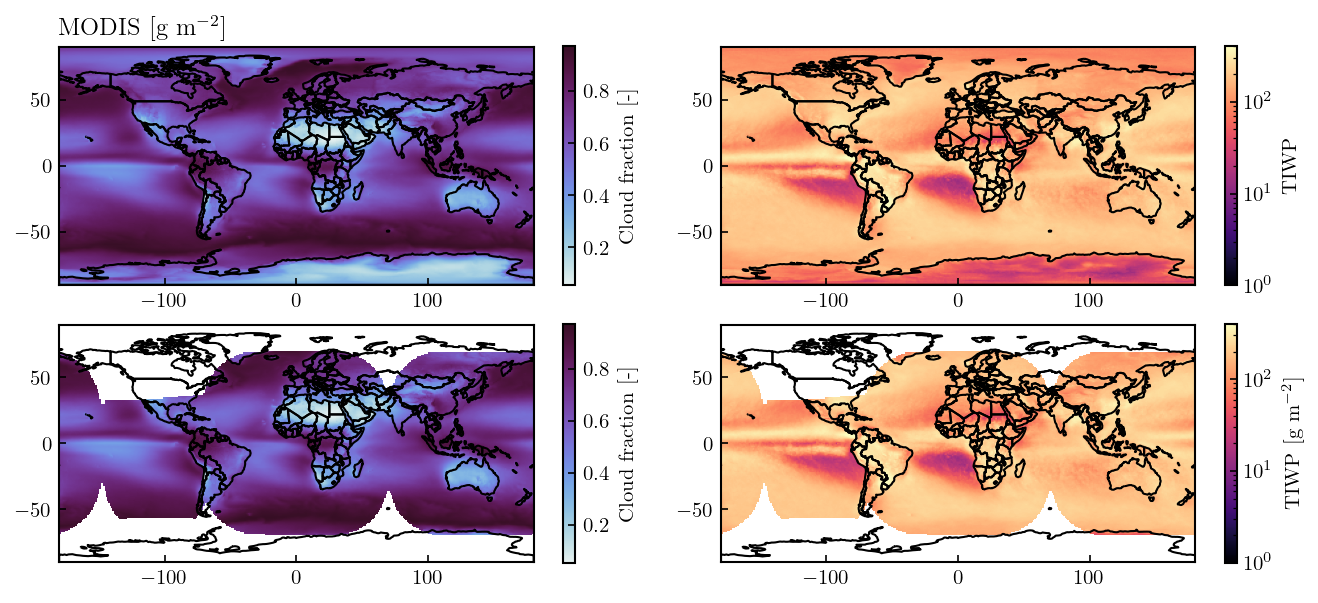

In [81]:
latitude = global_distribution['lat'][:]
longitude = global_distribution['lon'][:]

fig, axes = plt.subplots(2, 2, figsize = (9,4))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

extent = [longitude[0]-0.5, longitude[-1]+0.5, latitude[0]-0.5, latitude[-1]+0.5]

cax = axes[0,0].imshow(global_distribution["CF_global_distribution_unmasked"],
                     extent=extent)
cbar = fig.colorbar(cax)
cbar.set_label(r'Cloud fraction [-]')
world.boundary.plot(ax=axes[0,0], color='black', lw=1)
axes[0,0].set_title(r'MODIS [g m$^{-2}$]')

cax2 = axes[0,1].imshow(global_distribution["TIWP_global_distribution_unmasked"],
                      extent=extent,
                      norm=LogNorm(vmin=(1e0), vmax=4e2),
                     cmap='magma')
world.boundary.plot(ax=axes[0,1], color='black', lw=1)
cbar2 = fig.colorbar(cax2)
cbar2.set_label(r'TIWP')

cax = axes[1,0].imshow(global_distribution["CF_global_distribution_masked"],
                     extent=extent)
cbar = fig.colorbar(cax)
cbar.set_label(r'Cloud fraction [-]')
world.boundary.plot(ax=axes[1,0], color='black', lw=1)

cax2 = axes[1,1].imshow(global_distribution["TIWP_global_distribution_masked"],
                      extent=extent,
                      norm=LogNorm(vmin=(1e0), vmax=4e2),
                     cmap='magma')
world.boundary.plot(ax=axes[1,1], color='black', lw=1)
cbar2 = fig.colorbar(cax2)
cbar2.set_label(r'TIWP [g m$^{-2}$]')

fig.tight_layout()